In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/erinconeill/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
# Libraries
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import string
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from scipy.stats import ttest_ind
from scipy.stats import zscore

In [33]:
# Read file as dataframe
file = "Kenya Relief Survey.xlsx"
df = pd.read_excel(file)
df

,Gender,Age,Community,Do you have children,# of Children,Education level,Can you read,Job/Profession,Do you have a role in the community,Role in the Community,...,"If so, do you know the cause?.1","If you could access health talks and education, what would you like to learn?",Is there any non-governmental organization working in your community?,"If so, what do they do?",Is there any ongoing project from these organizations on the community right now?,What are the biggest health problems you and your family are facing?,What are the biggest health problems in your community?,How would you describe the health of your community?,If you could change something in your community what would you change?,If you could make a request for the community what would you ask for?
0,Female,32,Nyamome,yes,4,2 levels of High School,yes,Water Project seller,no,NaN,...,pneumonia,"Sanitation, How to keep children clean and hea...",no,NaN,no,Eye problems-in husband/children get sick with...,Measles+malaria in children,"mixed, som really healthy but the ones that ar...",Better health and sanitation,"Education, hard to find work. Better Sanitatio..."
1,Female,45,Luo,yes,7,3,no,school cleaner,no,NaN,...,NaN,hygiene,NaN,NaN,NaN,malaria,latrine,same,same,NaN
2,Female,54,Luo,yes,6,3rd,yes,sell bakery goods at school,no,village elder,...,heart failure,hygiene,NaN,NaN,no,malaria,no latrines,Big malaria and HIV problems,expand H2O project and clean water,Shed for shade to rest when people come to gather
3,Female,48,Nyamome,yes,5,7,some,small business owner-farmer,yes,farmer,...,meningitis,how to prevent malaria and meningitis,no,NaN,no,NaN,malaria and asthma,fair,community mill to grind flour,A bigger hospital
4,Male,60,Nyamome,yes,6,Village elder,yes,no,yes,village elder,...,"diarrhea, coughing, headache (TB)","""How my life could be better""",no,NaN,no,Not enough food.,Not enough food,poor health due to poor nutrition,More food,More food
5,Female,44,Nyamome,yes,6,7 grade,no - eye problems,Farmer,yes,farmer,...,cancer,how to prevent malaria and typhoid,no,NaN,no,Food shortage-balanced diet,typhoid,fair,somewhere to raise chickens for income - poult...,shopping to come near them so they don't have ...
6,Female,45,Nyamome,yes,5,8,yes,Farmer,yes,farmer,...,typhoid,how to prevent malaria and typhoid,no,NaN,NaN,Food shortage-balanced diet,muscle-skeletal problems - back pain,fair,sweet potato factory to increase income,grocery store nearer
7,Male,63,Nyamome,yes,10,7th,yes,community police,yes,community police,...,"malaria, cancer, typhoid, meningitis",how to live with AIDS,no,NaN,no,have farms but not enough for family,ulcers,"""in between"" - fair",farming - so they could get enough food and no...,a factory to help them with potatoes. Land to ...
8,Male,52,Nyamome,yes,5,7 classes,yes,farmer,yes,clan elder,...,malaria and typhoid,malaria,yes - Kenya Relief,NaN,yes - Water Project,"malaria, typhoid","malaria, typhoid, bilharzia",not healthy,how to get clean water,water
9,Male,49,Luo,yes,7,8,yes,no,no,NaN,...,lots,stop malaria,no,NaN,no,blood pressure/malaria,malaria /blood pressure,50/50 sick healthy,hospital,school


In [34]:
# Preprocessing data - answering baseline questions (i.e., how many communities, avg. age, female/male distribution)

# Gender
# Count the occurrences of each gender
gender_distribution = df['Gender'].value_counts()

# Display the distribution
print("Gender Distribution:")
for gender, count in gender_distribution.items():
    print(f"{gender}: {count}")
    
# Age
# Convert 'Age' column to numeric, coerce errors to NaN
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

# Calculate the average age
average_age = df['Age'].mean()
print(f"The average age is: {average_age:.2f} years")

# Count the number of unique communities and their names
unique_communities = df['Community'].nunique()
community_names = df['Community'].unique()
print(f"There are {unique_communities} unique communities.")
print("Unique community names:")
for community in community_names:
    print(community)

# Count the number of instances for each unique community
community_counts = df['Community'].value_counts()
print("\nNumber of instances for each unique community:")
print(community_counts)

# Number of children
# Convert '# of Children' column to numeric, coerce errors to NaN
df['# of Children'] = pd.to_numeric(df['# of Children'], errors='coerce')

# Calculate the average number of children
average_children = df['# of Children'].mean()
print(f"The average number of children is: {average_children:.2f}")

# Ideally -- organize communities into regions and create corresponding column (currently too many distinct communities)

Gender Distribution:
Female: 64
Male: 58
The average age is: 44.84 years
There are 75 unique communities.
Unique community names:
Nyamome
Luo
Lidha Village
Lisori
Nyangere
Matoso
Got Kachola
Migori
Nyandema
Lela Village
Kanyawanga
Konyango
Ongoro
Bande
Kowena
Uota Village
nan
Muhuru
Kakoth
Kodigo
Amoyo
Winam
Kwarani
Kiunei Village
Ishania
Tanzania
Mabera
Onba
Tukana
Ragana
Narok/Maasai
Kikoma
Kisii
Kuria
Suna Rabuov
Mayobo
Masai
Magina
Ndongo
Nyamkago Movi
Masaba
Nyanyuho
Kodnia
Kadika
Otugis
Muchabe
Sirare
Sori
Homa Bay County
Nyamasansa
Narok County
Nyarangi
Sayote
Nyakoe
Manyatta
Luo-Nayakach
Mosoch
Giribe
Oruba
Borega (Tanzania)
Homabay
Nyabounse
Suba Iambwe
Kikuyu
College Inn
Nyakach
Isbania
Karamu Community
Karamu
Karamu Water Project
Kuria/Kuria West Region
Kuria West Region
Kuria/Karaumu Water Project
Kugisingisi
Nyatike
Boremagongo

Number of instances for each unique community:
Community
Nyamome                        7
Luo                            6
Karamu                 

In [35]:
# Standardize distance data

# Function to convert various distance measurements to kilometers
def to_kilometers(distance_str):
    pattern_km = re.compile(r"(\d+(\.\d+)?)\s*(kilometer|kilometers|km)", re.IGNORECASE)
    pattern_m = re.compile(r"(\d+(\.\d+)?)\s*(meter|meters|m)", re.IGNORECASE)
    pattern_mi = re.compile(r"(\d+(\.\d+)?)\s*(mile|miles)", re.IGNORECASE)
    pattern_yd = re.compile(r"(\d+(\.\d+)?)\s*(yard|yards|yd)", re.IGNORECASE)
    
    # Function to convert units to kilometers
    def convert_unit(value, unit):
        if unit.lower() in ['kilometer', 'kilometers', 'km']:
            return float(value)
        elif unit.lower() in ['meter', 'meters', 'm']:
            return float(value) / 1000
        elif unit.lower() in ['mile', 'miles']:
            return float(value) * 1.60934
        elif unit.lower() in ['yard', 'yards', 'yd']:
            return float(value) * 0.0009144
        else:
            return None
    
    # Match each pattern to the distance string
    match_km = pattern_km.match(str(distance_str))
    match_m = pattern_m.match(str(distance_str))
    match_mi = pattern_mi.match(str(distance_str))
    match_yd = pattern_yd.match(str(distance_str))
    
    # Convert to kilometers based on the matched pattern
    if match_km:
        return convert_unit(match_km.group(1), match_km.group(3))
    elif match_m:
        return convert_unit(match_m.group(1), match_m.group(3))
    elif match_mi:
        return convert_unit(match_mi.group(1), match_mi.group(3))
    elif match_yd:
        return convert_unit(match_yd.group(1), match_yd.group(3))
    else:
        return None

# Apply the conversion function to each value in the column and store the results in a new column
df['Standardized Distance'] = df['How far is the health center?'].apply(to_kilometers)

display(df)

,Gender,Age,Community,Do you have children,# of Children,Education level,Can you read,Job/Profession,Do you have a role in the community,Role in the Community,...,"If you could access health talks and education, what would you like to learn?",Is there any non-governmental organization working in your community?,"If so, what do they do?",Is there any ongoing project from these organizations on the community right now?,What are the biggest health problems you and your family are facing?,What are the biggest health problems in your community?,How would you describe the health of your community?,If you could change something in your community what would you change?,If you could make a request for the community what would you ask for?,Standardized Distance
0,Female,32.0,Nyamome,yes,4.0,2 levels of High School,yes,Water Project seller,no,NaN,...,"Sanitation, How to keep children clean and hea...",no,NaN,no,Eye problems-in husband/children get sick with...,Measles+malaria in children,"mixed, som really healthy but the ones that ar...",Better health and sanitation,"Education, hard to find work. Better Sanitatio...",NaN
1,Female,45.0,Luo,yes,7.0,3,no,school cleaner,no,NaN,...,hygiene,NaN,NaN,NaN,malaria,latrine,same,same,NaN,NaN
2,Female,54.0,Luo,yes,6.0,3rd,yes,sell bakery goods at school,no,village elder,...,hygiene,NaN,NaN,no,malaria,no latrines,Big malaria and HIV problems,expand H2O project and clean water,Shed for shade to rest when people come to gather,NaN
3,Female,48.0,Nyamome,yes,5.0,7,some,small business owner-farmer,yes,farmer,...,how to prevent malaria and meningitis,no,NaN,no,NaN,malaria and asthma,fair,community mill to grind flour,A bigger hospital,4.00000
4,Male,60.0,Nyamome,yes,6.0,Village elder,yes,no,yes,village elder,...,"""How my life could be better""",no,NaN,no,Not enough food.,Not enough food,poor health due to poor nutrition,More food,More food,0.00400
5,Female,44.0,Nyamome,yes,6.0,7 grade,no - eye problems,Farmer,yes,farmer,...,how to prevent malaria and typhoid,no,NaN,no,Food shortage-balanced diet,typhoid,fair,somewhere to raise chickens for income - poult...,shopping to come near them so they don't have ...,4.00000
6,Female,45.0,Nyamome,yes,5.0,8,yes,Farmer,yes,farmer,...,how to prevent malaria and typhoid,no,NaN,NaN,Food shortage-balanced diet,muscle-skeletal problems - back pain,fair,sweet potato factory to increase income,grocery store nearer,4.00000
7,Male,63.0,Nyamome,yes,10.0,7th,yes,community police,yes,community police,...,how to live with AIDS,no,NaN,no,have farms but not enough for family,ulcers,"""in between"" - fair",farming - so they could get enough food and no...,a factory to help them with potatoes. Land to ...,4.00000
8,Male,52.0,Nyamome,yes,5.0,7 classes,yes,farmer,yes,clan elder,...,malaria,yes - Kenya Relief,NaN,yes - Water Project,"malaria, typhoid","malaria, typhoid, bilharzia",not healthy,how to get clean water,water,4.00000
9,Male,49.0,Luo,yes,7.0,8,yes,no,no,NaN,...,stop malaria,no,NaN,no,blood pressure/malaria,malaria /blood pressure,50/50 sick healthy,hospital,school,0.00300


In [36]:
# Standardize 'days off' data

# Define a function to convert values with 'weeks' to days
def convert_weeks_to_days(value):
    if isinstance(value, str):
        pattern_weeks = re.compile(r"\b(\d+)\s*week(s)?\b", re.IGNORECASE)
        match = pattern_weeks.search(value)
        if match:
            weeks = int(match.group(1))
            return weeks * 7  # Convert weeks to days
    return value

# Convert values with 'weeks' to days
df['How many days have you missed work this year due to illness?'] = df['How many days have you missed work this year due to illness?'].apply(convert_weeks_to_days)

# Define a function to standardize the values in the column
def standardize_days(str_value):
    if str_value in ['N/A', 'n/a', 'na', 'none', 'not working', 'no', 'none.', 'none ']:
        return np.nan
    else:
        pattern_num = re.compile(r"(\d+)")
        match = pattern_num.search(str(str_value))
        if match:
            return int(match.group(1))
        else:
            return np.nan

# Apply the standardization function to each value in the column and store the results in a new column
df['Days Unable to Work'] = df['How many days have you missed work this year due to illness?'].apply(standardize_days)

display(df)


,Gender,Age,Community,Do you have children,# of Children,Education level,Can you read,Job/Profession,Do you have a role in the community,Role in the Community,...,Is there any non-governmental organization working in your community?,"If so, what do they do?",Is there any ongoing project from these organizations on the community right now?,What are the biggest health problems you and your family are facing?,What are the biggest health problems in your community?,How would you describe the health of your community?,If you could change something in your community what would you change?,If you could make a request for the community what would you ask for?,Standardized Distance,Days Unable to Work
0,Female,32.0,Nyamome,yes,4.0,2 levels of High School,yes,Water Project seller,no,NaN,...,no,NaN,no,Eye problems-in husband/children get sick with...,Measles+malaria in children,"mixed, som really healthy but the ones that ar...",Better health and sanitation,"Education, hard to find work. Better Sanitatio...",NaN,NaN
1,Female,45.0,Luo,yes,7.0,3,no,school cleaner,no,NaN,...,NaN,NaN,NaN,malaria,latrine,same,same,NaN,NaN,5.0
2,Female,54.0,Luo,yes,6.0,3rd,yes,sell bakery goods at school,no,village elder,...,NaN,NaN,no,malaria,no latrines,Big malaria and HIV problems,expand H2O project and clean water,Shed for shade to rest when people come to gather,NaN,3.0
3,Female,48.0,Nyamome,yes,5.0,7,some,small business owner-farmer,yes,farmer,...,no,NaN,no,NaN,malaria and asthma,fair,community mill to grind flour,A bigger hospital,4.00000,6.0
4,Male,60.0,Nyamome,yes,6.0,Village elder,yes,no,yes,village elder,...,no,NaN,no,Not enough food.,Not enough food,poor health due to poor nutrition,More food,More food,0.00400,NaN
5,Female,44.0,Nyamome,yes,6.0,7 grade,no - eye problems,Farmer,yes,farmer,...,no,NaN,no,Food shortage-balanced diet,typhoid,fair,somewhere to raise chickens for income - poult...,shopping to come near them so they don't have ...,4.00000,5.0
6,Female,45.0,Nyamome,yes,5.0,8,yes,Farmer,yes,farmer,...,no,NaN,NaN,Food shortage-balanced diet,muscle-skeletal problems - back pain,fair,sweet potato factory to increase income,grocery store nearer,4.00000,3.0
7,Male,63.0,Nyamome,yes,10.0,7th,yes,community police,yes,community police,...,no,NaN,no,have farms but not enough for family,ulcers,"""in between"" - fair",farming - so they could get enough food and no...,a factory to help them with potatoes. Land to ...,4.00000,4.0
8,Male,52.0,Nyamome,yes,5.0,7 classes,yes,farmer,yes,clan elder,...,yes - Kenya Relief,NaN,yes - Water Project,"malaria, typhoid","malaria, typhoid, bilharzia",not healthy,how to get clean water,water,4.00000,NaN
9,Male,49.0,Luo,yes,7.0,8,yes,no,no,NaN,...,no,NaN,no,blood pressure/malaria,malaria /blood pressure,50/50 sick healthy,hospital,school,0.00300,NaN


In [37]:
# What were the top changes that persons in leadership would like to see occur? 
# Filter by leadership and communities (too many communities for meaningful analysis)

# Create sub-dataframes for leadership and non-leadership roles
leadership = df[df['Do you have a role in the community'] == 'yes']
non_leadership = df[df['Do you have a role in the community'] == 'no']

# Display the first few rows of each sub-dataframe
print("Leadership Sub-DataFrame:")
display(leadership) # 50 observations

print("\nNon-Leadership Sub-DataFrame:")
display(non_leadership) # 70 observations 

def get_top_keywords(df, column_name):
    stop_words = set(stopwords.words('english'))

    # Concatenate all responses into a single string
    all_responses = ' '.join(df[column_name].dropna())

    # Tokenize the responses into words
    words = re.findall(r'\w+', all_responses.lower())

    # Filter out stopwords
    filtered_words = [word for word in words if word not in stop_words]

    # Count the occurrences of each word
    word_counts = Counter(filtered_words)

    # Get the top 5 most common keywords
    top_keywords = word_counts.most_common(5)

    return top_keywords

# 'If you could change something in your community what would you change?' column in leadership dataframe
top_keywords_change = get_top_keywords(leadership, "If you could change something in your community what would you change?")
print("Top 5 keywords in 'If you could change something in your community what would you change?':")
for keyword, count in top_keywords_change:
    print(f"{keyword}: {count} occurrences")

# 'If you could make a request for the community what would you ask for?' column in leadership dataframe
top_keywords_request = get_top_keywords(leadership, "If you could make a request for the community what would you ask for?")
print("\nTop 5 keywords in 'If you could make a request for the community what would you ask for?':")
for keyword, count in top_keywords_request:
    print(f"{keyword}: {count} occurrences")

    
def categorize_responses(df, column_name):
    categories = {
        'health': ['health', 'medical', 'clinic', 'hospital', 'doctor', 'medicine', 'care'],
        'education': ['education', 'school', 'teacher', 'classroom', 'learning', 'library', 'college', 'university'],
        'food': ['food', 'nutrition', 'hunger', 'meal', 'nutrition', 'diet', 'grocery', 'eat'],
        'housing': ['housing', 'homeless', 'shelter', 'house', 'living', 'residence', 'accommodation'],
        'employment': ['employment', 'job', 'work', 'career', 'occupation', 'unemployment', 'income'],
        'environment': ['environment', 'clean', 'pollution', 'polluted', 'water', 'sanitation', 'hygiene'],
        'social_support': ['social', 'community', 'support', 'network', 'friend', 'family', 'neighbor', 'belonging']
        # Add more categories and associated keywords as needed
    }

    # Initialize category counts
    category_counts = {category: 0 for category in categories}

    # Concatenate all responses into a single string
    all_responses = ' '.join(df[column_name].dropna())

    # Tokenize the responses into words
    words = re.findall(r'\w+', all_responses.lower())

    # Categorize each word in the responses
    for word in words:
        for category, keywords in categories.items():
            if any(keyword in word for keyword in keywords):
                category_counts[category] += 1

    return category_counts

# 'If you could change something in your community what would you change?' column
category_counts_change = categorize_responses(leadership, "If you could change something in your community what would you change?")
print("Category counts for 'If you could change something in your community what would you change?':")
print(category_counts_change)

# 'If you could make a request for the community what would you ask for?' column
category_counts_request = categorize_responses(leadership, "If you could make a request for the community what would you ask for?")
print("\nCategory counts for 'If you could make a request for the community what would you ask for?':")
print(category_counts_request)


Leadership Sub-DataFrame:


,Gender,Age,Community,Do you have children,# of Children,Education level,Can you read,Job/Profession,Do you have a role in the community,Role in the Community,...,Is there any non-governmental organization working in your community?,"If so, what do they do?",Is there any ongoing project from these organizations on the community right now?,What are the biggest health problems you and your family are facing?,What are the biggest health problems in your community?,How would you describe the health of your community?,If you could change something in your community what would you change?,If you could make a request for the community what would you ask for?,Standardized Distance,Days Unable to Work
3,Female,48.0,Nyamome,yes,5.0,7,some,small business owner-farmer,yes,farmer,...,no,NaN,no,NaN,malaria and asthma,fair,community mill to grind flour,A bigger hospital,4.000,6.0
4,Male,60.0,Nyamome,yes,6.0,Village elder,yes,no,yes,village elder,...,no,NaN,no,Not enough food.,Not enough food,poor health due to poor nutrition,More food,More food,0.004,NaN
5,Female,44.0,Nyamome,yes,6.0,7 grade,no - eye problems,Farmer,yes,farmer,...,no,NaN,no,Food shortage-balanced diet,typhoid,fair,somewhere to raise chickens for income - poult...,shopping to come near them so they don't have ...,4.000,5.0
6,Female,45.0,Nyamome,yes,5.0,8,yes,Farmer,yes,farmer,...,no,NaN,NaN,Food shortage-balanced diet,muscle-skeletal problems - back pain,fair,sweet potato factory to increase income,grocery store nearer,4.000,3.0
7,Male,63.0,Nyamome,yes,10.0,7th,yes,community police,yes,community police,...,no,NaN,no,have farms but not enough for family,ulcers,"""in between"" - fair",farming - so they could get enough food and no...,a factory to help them with potatoes. Land to ...,4.000,4.0
8,Male,52.0,Nyamome,yes,5.0,7 classes,yes,farmer,yes,clan elder,...,yes - Kenya Relief,NaN,yes - Water Project,"malaria, typhoid","malaria, typhoid, bilharzia",not healthy,how to get clean water,water,4.000,NaN
10,Male,50.0,Luo,yes,8.0,8,yes,no,yes,secretary,...,no,NaN,no,blood pressure/malaria,blood pressure/malaria,50/50 sick healthy,hospital,NaN,0.003,NaN
12,Female,50.0,Lidha Village,yes,7.0,7 grade,yes,businesswoman - store,yes,treasurer,...,no,NaN,no,hypertension,HIV + AIDS,a lot are sick,safe water - make life better,NaN,0.030,2.0
13,Male,24.0,Lisori,no,0.0,College,NaN,Self Employment,yes,Nums Reg. Asst./Short Time,...,yes,They offer general hospital services and train...,no,headache and malaria at times,HIV,It's so poor,I could change the living standards of both pe...,Improvement of all people's living standards a...,NaN,NaN
17,Male,56.0,Migori,yes,4.0,2,yes,pastor,yes,NaN,...,yes - Kenya Relief,NaN,no,malaria/ heaviness of arms/limbs pain,AIDS,"not healthy AIDS, malaria",need more income generations - to provide food,NaN,5.000,2.0



Non-Leadership Sub-DataFrame:


,Gender,Age,Community,Do you have children,# of Children,Education level,Can you read,Job/Profession,Do you have a role in the community,Role in the Community,...,Is there any non-governmental organization working in your community?,"If so, what do they do?",Is there any ongoing project from these organizations on the community right now?,What are the biggest health problems you and your family are facing?,What are the biggest health problems in your community?,How would you describe the health of your community?,If you could change something in your community what would you change?,If you could make a request for the community what would you ask for?,Standardized Distance,Days Unable to Work
0,Female,32.0,Nyamome,yes,4.0,2 levels of High School,yes,Water Project seller,no,NaN,...,no,NaN,no,Eye problems-in husband/children get sick with...,Measles+malaria in children,"mixed, som really healthy but the ones that ar...",Better health and sanitation,"Education, hard to find work. Better Sanitatio...",NaN,NaN
1,Female,45.0,Luo,yes,7.0,3,no,school cleaner,no,NaN,...,NaN,NaN,NaN,malaria,latrine,same,same,NaN,NaN,5.0
2,Female,54.0,Luo,yes,6.0,3rd,yes,sell bakery goods at school,no,village elder,...,NaN,NaN,no,malaria,no latrines,Big malaria and HIV problems,expand H2O project and clean water,Shed for shade to rest when people come to gather,NaN,3.0
9,Male,49.0,Luo,yes,7.0,8,yes,no,no,NaN,...,no,NaN,no,blood pressure/malaria,malaria /blood pressure,50/50 sick healthy,hospital,school,0.00300,NaN
11,Female,40.0,Lidha Village,yes,3.0,Primary,yes,business,no,NaN,...,no,NaN,no,eye problem,malaria and typhoid,typhoid and malaria is rampant,safe water,health center,3.00000,NaN
14,Female,35.0,Nyangere,yes,3.0,Primary,NaN,Business,no,NaN,...,yes,Testing for HIV/AIDS,no,stomach problems,stomach problems,unhealthy,drinking water,drinking water,0.01000,10.0
15,Male,20.0,Matoso,no,0.0,Secondary,yes,"""hustling""",no,NaN,...,yes,"LAMBA - sponsor orphans, treat, education",yes,eye problems,malaria,most are sick,living system - struggling with life need food...,educate people health issues,0.00100,NaN
16,Female,32.0,Got Kachola,no,0.0,Primary,no,fishing,no,NaN,...,no,NaN,no,eye problems; malaria,eye problems,most are sick - hospital,clear tap water,bring in a hospital 2k closest one,2.00000,5.0
19,Male,10.0,Nyandema,yes,5.0,Primary,yes,tailoring,no,NaN,...,no,NaN,no,Headache,Malaria,NaN,clean drinking water,drinking water,1.00000,4.0
20,Female,53.0,Lisori,yes,6.0,Primary,NaN,none,no,NaN,...,NaN,NaN,no,stomach problems,swelling of stomach,many people are sick,disposal of harmful substances,safe drinking water,1.00000,NaN


Top 5 keywords in 'If you could change something in your community what would you change?':
water: 25 occurrences
clean: 14 occurrences
people: 10 occurrences
health: 8 occurrences
get: 5 occurrences

Top 5 keywords in 'If you could make a request for the community what would you ask for?':
water: 22 occurrences
clean: 9 occurrences
health: 7 occurrences
safe: 6 occurrences
help: 4 occurrences
Category counts for 'If you could change something in your community what would you change?':
{'health': 14, 'education': 4, 'food': 9, 'housing': 2, 'employment': 4, 'environment': 43, 'social_support': 5}

Category counts for 'If you could make a request for the community what would you ask for?':
{'health': 12, 'education': 2, 'food': 5, 'housing': 1, 'employment': 0, 'environment': 32, 'social_support': 4}


In [38]:
# What were the top changes at persons not in leadership would like to see occur?
# Filter by leadership and communities (too many communities for meaningful analysis)

# 'If you could change something in your community what would you change?' column in non-leadership dataframe
top_keywords_change = get_top_keywords(non_leadership, "If you could change something in your community what would you change?")
print("Top 5 keywords in 'If you could change something in your community what would you change?':")
for keyword, count in top_keywords_change:
    print(f"{keyword}: {count} occurrences")

# 'If you could make a request for the community what would you ask for?' column in non-leadership dataframe
top_keywords_request = get_top_keywords(non_leadership, "If you could make a request for the community what would you ask for?")
print("\nTop 5 keywords in 'If you could make a request for the community what would you ask for?':")
for keyword, count in top_keywords_request:
    print(f"{keyword}: {count} occurrences")

# 'If you could change something in your community what would you change?' column
category_counts_change = categorize_responses(non_leadership, "If you could change something in your community what would you change?")
print("Category counts for 'If you could change something in your community what would you change?':")
print(category_counts_change)

# 'If you could make a request for the community what would you ask for?' column
category_counts_request = categorize_responses(non_leadership, "If you could make a request for the community what would you ask for?")
print("\nCategory counts for 'If you could make a request for the community what would you ask for?':")
print(category_counts_request)

# Rank in order the most important request that each of these communities would like to have fulfilled 
# environment, health, social support, education, food, housing, employment 


Top 5 keywords in 'If you could change something in your community what would you change?':
water: 35 occurrences
community: 13 occurrences
hospital: 12 occurrences
health: 11 occurrences
safe: 8 occurrences

Top 5 keywords in 'If you could make a request for the community what would you ask for?':
water: 26 occurrences
community: 16 occurrences
health: 14 occurrences
help: 12 occurrences
safe: 8 occurrences
Category counts for 'If you could change something in your community what would you change?':
{'health': 32, 'education': 3, 'food': 8, 'housing': 3, 'employment': 1, 'environment': 43, 'social_support': 13}

Category counts for 'If you could make a request for the community what would you ask for?':
{'health': 25, 'education': 7, 'food': 6, 'housing': 2, 'employment': 2, 'environment': 33, 'social_support': 16}


In [39]:
# Define stopwords
stop_words = set(stopwords.words('english'))

# Function to process text
def process_text(text):
    # Normalize case and split text based on delimiters and stopwords
    words = re.split(r',|;|\band\b|\s+|\"|-', text.lower())
    words = [word.strip() for word in words if word.strip() and word not in stop_words]
    return words

# Set display options
pd.set_option('display.max_rows', None)

# Process the column 'What diseases are more frequent at home'
disease_counts_1 = df['What diseases are more frequent at home'].dropna().apply(process_text).explode().value_counts()
display(disease_counts_1)

# Process the column 'What are the biggest health problems you and your family are facing?'
disease_counts_2 = df['What are the biggest health problems you and your family are facing?'].dropna().apply(process_text).explode().value_counts()
display(disease_counts_2)

# Process the column 'What are the biggest health problems in your community?'
disease_counts_3 = df['What are the biggest health problems in your community? '].dropna().apply(process_text).explode().value_counts()
display(disease_counts_3)

What diseases are more frequent at home
malaria              77
typhoid              26
problems             19
stomach              11
ulcers                9
eye                   9
water                 8
borne                 8
diseases              8
asthma                7
blood                 7
cough                 7
pressure              7
diabetes              6
pain                  5
headache              5
ache                  5
headaches             5
arthritis             5
amoebiasis            5
cholera               4
allergies             3
flu                   3
chest                 3
brucellosis           2
dental                2
throat                2
hiv                   2
skin                  2
back                  2
goiter                2
diarrhea              2
aids                  2
high                  2
urination             1
chest/respiratory     1
coughing              1
abdomen               1
cancer                1
malaria/flu           1


What are the biggest health problems you and your family are facing?
malaria             49
problems            20
typhoid             15
blood               14
water               10
eye                  9
pressure             9
stomach              8
hiv                  7
diseases             7
arthritis            6
health               6
borne                5
high                 5
hypertension         5
pressure/malaria     5
chest                5
cough                4
clean                4
cancer               4
diabetes             4
issues               4
lack                 3
headache             3
ache                 3
low                  3
pain                 3
sexual               2
brucellosis          2
drive                2
asthma               2
hernia               2
general              2
pneumonia            2
back                 2
cost                 2
ulcers               2
enough               2
dental               2
food                 2
shortage   

What are the biggest health problems in your community? 
malaria               59
hiv                   29
typhoid               23
water                 12
cancer                 9
pressure               7
aids                   7
blood                  6
lack                   6
problems               6
hiv/aids               5
clean                  5
diabetes               5
cholera                4
diseases               4
arthritis              4
health                 4
stomach                3
high                   3
community              3
borne                  3
gives                  2
food                   2
eye                    2
cough                  2
ulcers                 2
asthma                 2
money                  2
hypertension           2
hole                   1
amoebiasis             1
safe                   1
mental                 1
problematic            1
itchy                  1
skin                   1
deterrents             1
frequency         

/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


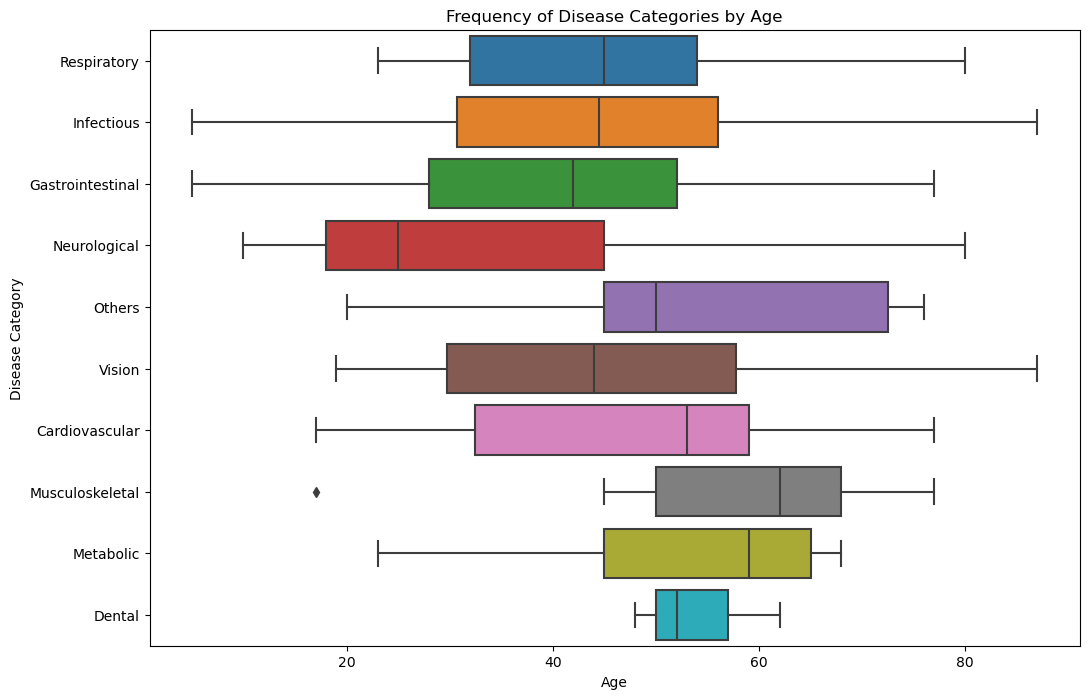

/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

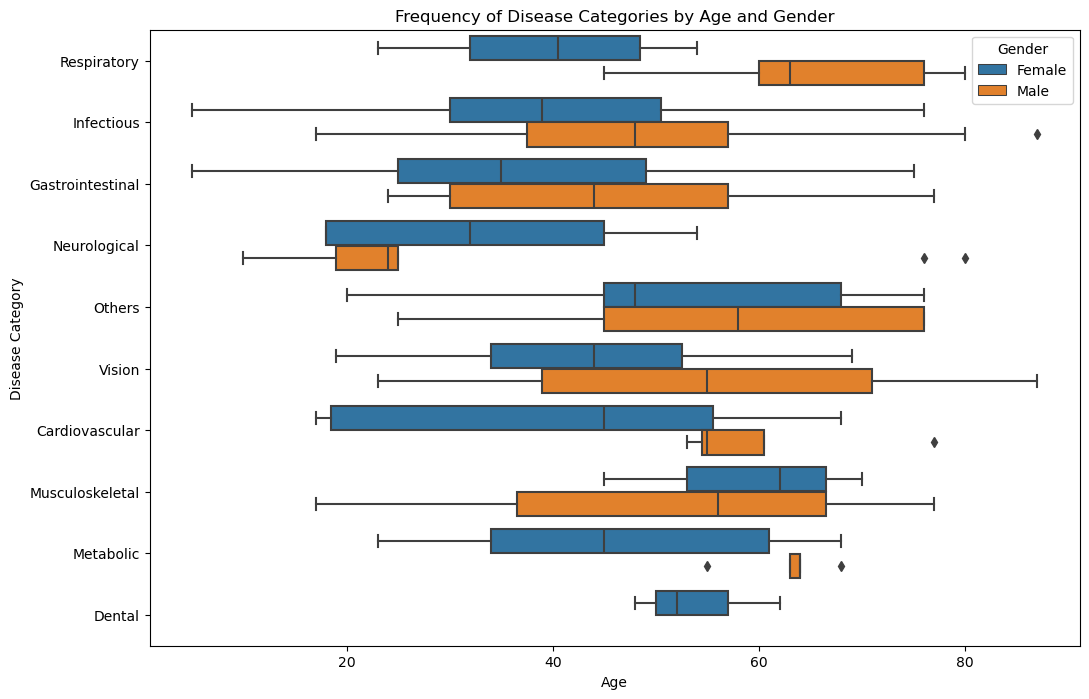

In [40]:
# Function to categorize diseases
def categorize_diseases(disease):
    respiratory_keywords = ['cough', 'chest/respiratory', 'pneumonia', 'asthma']
    gastrointestinal_keywords = ['stomach virus', 'stomachache', 'typhoid', 'ulcers', 'abdominal pain', 'enuresis', 'diarrhea', 'water-borne diseases', 'cholera', 'amoebiasis']
    vision_keywords = ['eye problems']
    cardiovascular_keywords = ['chest problems', 'chest pain', 'high blood pressure', 'blood pressure']
    musculoskeletal_keywords = ['arthritis', 'back ache', 'knee problems', 'pain in the knees', 'skin disease']
    neurological_keywords = ['headaches', 'headache', 'epilepsy', 'fevers', 'lipoma', 'neck problems', 'depression']
    dental_keywords = ['tooth decay', 'dental']
    metabolic_keywords = ['diabetes', 'sickle cell', 'goiter', 'growth', 'thyroid problems', 'numbness']
    infectious_keywords = ['malaria', 'flu', 'AIDS', 'HIV', 'brucellosis', 'wounds', 'cholera', 'typhoid', 'amoebiasis', 'water-borne diseases', 'diarrhea', 'flu', 'tuberculosis']
    others = ['allergies', 'cancer', 'urinal problems', 'itching skin', 'nauseated', 'sleepless nights', 'kids suffering', 'milk/chicken diseases']

    categories = []
    for keyword in respiratory_keywords:
        if keyword in str(disease):
            categories.append('Respiratory')
    
    for keyword in gastrointestinal_keywords:
        if keyword in str(disease):
            categories.append('Gastrointestinal')
    
    for keyword in vision_keywords:
        if keyword in str(disease):
            categories.append('Vision')
    
    for keyword in cardiovascular_keywords:
        if keyword in str(disease):
            categories.append('Cardiovascular')
    
    for keyword in musculoskeletal_keywords:
        if keyword in str(disease):
            categories.append('Musculoskeletal')
    
    for keyword in neurological_keywords:
        if keyword in str(disease):
            categories.append('Neurological')
    
    for keyword in dental_keywords:
        if keyword in str(disease):
            categories.append('Dental')
    
    for keyword in metabolic_keywords:
        if keyword in str(disease):
            categories.append('Metabolic')
    
    for keyword in infectious_keywords:
        if keyword in str(disease):
            categories.append('Infectious')
    
    for keyword in others:
        if keyword in str(disease):
            categories.append('Others')
    
    return categories if categories else ['Others']

# Apply categorization
df['Disease Category'] = df['What diseases are more frequent at home'].apply(categorize_diseases)

# Plotting
plt.figure(figsize=(12, 8))
sns.boxplot(x='Age', y='Disease Category', data=df.explode('Disease Category')) 
# Exploding the dataframe ensures that if multiple disease categories are recorded under and individual that they're independently represented
plt.xlabel('Age')
plt.ylabel('Disease Category')
plt.title('Frequency of Disease Categories by Age')
plt.show()

# Plotting
plt.figure(figsize=(12, 8))
sns.boxplot(x='Age', y='Disease Category', hue='Gender', data=df.explode('Disease Category')) 
# Exploding the dataframe ensures that if multiple disease categories are recorded under an individual, they're independently represented
plt.xlabel('Age')
plt.ylabel('Disease Category')
plt.title('Frequency of Disease Categories by Age and Gender')
plt.legend(title='Gender')


In [41]:
df

,Gender,Age,Community,Do you have children,# of Children,Education level,Can you read,Job/Profession,Do you have a role in the community,Role in the Community,...,"If so, what do they do?",Is there any ongoing project from these organizations on the community right now?,What are the biggest health problems you and your family are facing?,What are the biggest health problems in your community?,How would you describe the health of your community?,If you could change something in your community what would you change?,If you could make a request for the community what would you ask for?,Standardized Distance,Days Unable to Work,Disease Category
0,Female,32.0,Nyamome,yes,4.0,2 levels of High School,yes,Water Project seller,no,NaN,...,NaN,no,Eye problems-in husband/children get sick with...,Measles+malaria in children,"mixed, som really healthy but the ones that ar...",Better health and sanitation,"Education, hard to find work. Better Sanitatio...",NaN,NaN,"[Respiratory, Respiratory, Respiratory, Infect..."
1,Female,45.0,Luo,yes,7.0,3,no,school cleaner,no,NaN,...,NaN,NaN,malaria,latrine,same,same,NaN,NaN,5.0,"[Gastrointestinal, Neurological, Neurological,..."
2,Female,54.0,Luo,yes,6.0,3rd,yes,sell bakery goods at school,no,village elder,...,NaN,no,malaria,no latrines,Big malaria and HIV problems,expand H2O project and clean water,Shed for shade to rest when people come to gather,NaN,3.0,[Respiratory]
3,Female,48.0,Nyamome,yes,5.0,7,some,small business owner-farmer,yes,farmer,...,NaN,no,NaN,malaria and asthma,fair,community mill to grind flour,A bigger hospital,4.00000,6.0,"[Respiratory, Infectious]"
4,Male,60.0,Nyamome,yes,6.0,Village elder,yes,no,yes,village elder,...,NaN,no,Not enough food.,Not enough food,poor health due to poor nutrition,More food,More food,0.00400,NaN,"[Respiratory, Gastrointestinal]"
5,Female,44.0,Nyamome,yes,6.0,7 grade,no - eye problems,Farmer,yes,farmer,...,NaN,no,Food shortage-balanced diet,typhoid,fair,somewhere to raise chickens for income - poult...,shopping to come near them so they don't have ...,4.00000,5.0,"[Respiratory, Infectious]"
6,Female,45.0,Nyamome,yes,5.0,8,yes,Farmer,yes,farmer,...,NaN,NaN,Food shortage-balanced diet,muscle-skeletal problems - back pain,fair,sweet potato factory to increase income,grocery store nearer,4.00000,3.0,"[Respiratory, Infectious]"
7,Male,63.0,Nyamome,yes,10.0,7th,yes,community police,yes,community police,...,NaN,no,have farms but not enough for family,ulcers,"""in between"" - fair",farming - so they could get enough food and no...,a factory to help them with potatoes. Land to ...,4.00000,4.0,"[Respiratory, Gastrointestinal, Infectious]"
8,Male,52.0,Nyamome,yes,5.0,7 classes,yes,farmer,yes,clan elder,...,NaN,yes - Water Project,"malaria, typhoid","malaria, typhoid, bilharzia",not healthy,how to get clean water,water,4.00000,NaN,[Infectious]
9,Male,49.0,Luo,yes,7.0,8,yes,no,no,NaN,...,NaN,no,blood pressure/malaria,malaria /blood pressure,50/50 sick healthy,hospital,school,0.00300,NaN,"[Gastrointestinal, Infectious, Infectious]"


Pearson correlation coefficient: 0.26580098515358974
Pearson correlation coefficient: 0.26580098515358974


/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


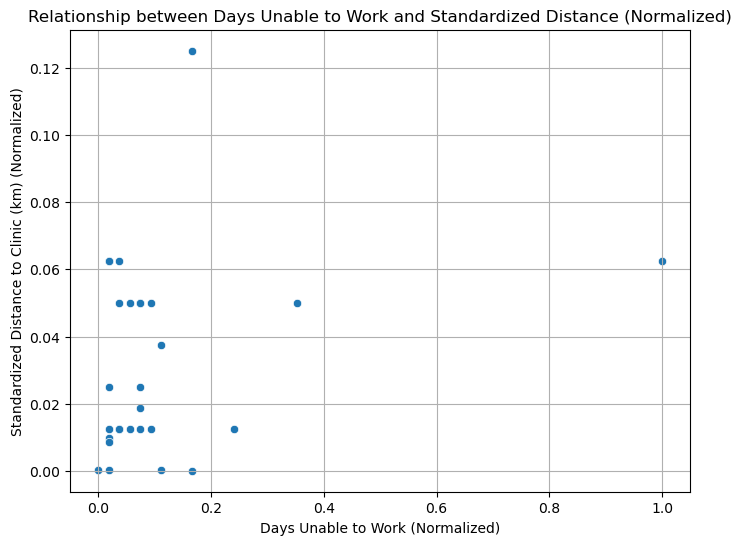

/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


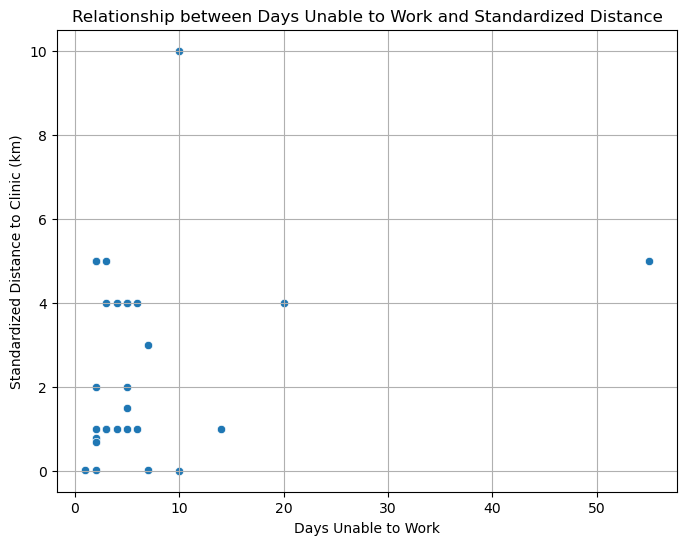

In [44]:
# Find the the maximum value in the col and remove (outlier)
max_index = df['Days Unable to Work'].idxmax()
df = df.drop(max_index)

# Min-max normalization function
def min_max_normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Normalize the columns
df['Days Unable to Work Normalized'] = min_max_normalize(df['Days Unable to Work'])
df['Standardized Distance Normalized'] = min_max_normalize(df['Standardized Distance'])

# Calculate Pearson correlation coefficient
correlation_coefficient = df['Standardized Distance Normalized'].corr(df['Days Unable to Work Normalized'])

# Calculate Pearson correlation coefficient
correlation_coefficient = df['Standardized Distance'].corr(df['Days Unable to Work'])
print("Pearson correlation coefficient:", correlation_coefficient)

# Visualize the data with a scatter plot - NORMALIZED
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Days Unable to Work Normalized', y='Standardized Distance Normalized', data=df)
plt.xlabel('Days Unable to Work (Normalized)')
plt.ylabel('Standardized Distance to Clinic (km) (Normalized)')
plt.title('Relationship between Days Unable to Work and Standardized Distance (Normalized)')
plt.grid(True)
plt.show()

# Visualize the data with a scatter plot - NOT NORMALIZED
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Days Unable to Work', y='Standardized Distance', data=df)
plt.xlabel('Days Unable to Work')
plt.ylabel('Standardized Distance to Clinic (km)')
plt.title('Relationship between Days Unable to Work and Standardized Distance')
plt.grid(True)
plt.show()

# Correlation coefficient is positive but relatively low (close to 0)
# It suggests a weak positive linear relationship between the variables
# Some tendency for the number of days taken off work to increase slightly as the distance to the clinic increases, but the relationship is not strong

In [17]:
def record_common_words(df, column_name):
    # Get the stopwords and punctuation marks
    stop_words = set(stopwords.words('english'))
    ignore_punctuation = set(string.punctuation)

    # Initialize Counter object to record common words
    common_words = Counter()

    # Tokenize and record common words
    for text in df[column_name]:
        # Check if the value is not NaN
        if not pd.isnull(text):
            # Convert to string and tokenize
            words = word_tokenize(str(text).lower())
            common_words.update([word for word in words if word not in stop_words and word not in ignore_punctuation])

    return common_words

common_words = record_common_words(df, 'If you could access health talks and education, what would you like to learn?')

print("Common Words:")
print(common_words)

def record_common_phrases(df, column_name, n=2):
    # Get the stopwords and punctuation marks
    stop_words = set(stopwords.words('english'))
    ignore_punctuation = set(string.punctuation)

    # Initialize Counter object to record phrases
    count_phrases = Counter()

    # Tokenize and record phrases
    for text in df[column_name]:
        # Check if the value is not NaN
        if not pd.isnull(text):
            # Remove specified punctuation marks
            text = ''.join(char for char in text if char not in ignore_punctuation)
            # Convert to string and tokenize
            words = word_tokenize(str(text).lower())
            # Generate n-grams
            phrases = ngrams(words, n)
            count_phrases.update([' '.join(phrase) for phrase in phrases if all(word not in stop_words for word in phrase)])

    return count_phrases

phrases = record_common_phrases(df, 'If you could access health talks and education, what would you like to learn?', n=2)

print(phrases)

def identify_target_words(count_phrases, num_words=5, min_frequency=1):
    # Get the stopwords
    stop_words = set(stopwords.words('english'))

    # Extract all words from phrases, ignoring punctuation
    all_words = [word for phrase in count_phrases.keys() for word in phrase.split() if word not in string.punctuation]

    # Count the frequency of each word
    word_counts = Counter(all_words)

    # Remove stopwords and filter by minimum frequency
    filtered_words = {word: count for word, count in word_counts.items() if word not in stop_words and count >= min_frequency}

    # Get the most common words
    top_words = [word for word, count in Counter(filtered_words).most_common(num_words)]

    return top_words

identified_target_words = identify_target_words(phrases)

print("Identified Target Words:")
print(identified_target_words)

def categorize_phrases_by_common_words(common_phrases, target_words):
    categorized_phrases = {word: Counter() for word in target_words}

    # Iterate through common phrases
    for phrase, count in common_phrases.items():
        # Check if the phrase contains any of the target words
        for word in target_words:
            if word in phrase:
                # If found, add the phrase to the corresponding category
                categorized_phrases[word][phrase] += count

    return categorized_phrases

target_words = ['prevent', 'diseases', 'malaria', 'hygiene', 'health']  # Add more target words as needed
categorized_phrases = categorize_phrases_by_common_words(phrases, target_words)

for word, phrases in categorized_phrases.items():
    print(f"Phrases containing '{word}':")
    print(phrases)

Common Words:
Counter({'malaria': 32, 'prevent': 21, 'diseases': 16, 'hygiene': 13, 'know': 12, 'would': 11, 'like': 11, 'learn': 10, 'health': 10, 'prevention': 9, 'cancer': 9, 'hiv': 8, 'water': 8, 'typhoid': 7, 'clean': 6, 'healthy': 5, 'blood': 5, 'illnesses': 5, 'measures': 5, 'causes': 5, 'diabetes': 5, 'aids': 4, 'help': 4, 'problems': 4, 'hiv/aids': 4, 'stomach': 4, 'pressure': 4, 'children': 3, 'family': 3, 'using': 3, 'safe': 3, 'western': 3, 'community': 3, 'get': 3, 'sanitation': 2, 'life': 2, 'could': 2, 'live': 2, 'stop': 2, 'people': 2, 'control': 2, 'cleanliness': 2, 'cure': 2, 'hypertension': 2, 'talks': 2, 'disease': 2, 'infectious': 2, 'general': 2, 'preventing': 2, 'hiv-aids': 2, 'stay': 2, 'medicine': 2, 'treatment': 2, 'warning': 2, 'signs': 2, 'brucellosis': 2, 'environment': 2, 'treat': 2, 'aches': 2, 'medications': 2, 'preventative': 2, 'education': 2, 'sickness': 2, 'keep': 1, 'meningitis': 1, '``': 1, 'better': 1, "''": 1, 'protect': 1, 'contact/contract': 1,

             Age  # of Children  # of Rooms in House  Standardized Distance  \
count  39.000000      34.000000            39.000000              29.000000   
mean   42.076923       4.558824             3.589744               2.554483   
std    14.636624       2.451854             1.956339               2.261050   
min    10.000000       0.000000             2.000000               0.010000   
25%    31.000000       3.000000             2.500000               1.000000   
50%    45.000000       5.000000             3.000000               2.000000   
75%    51.000000       6.000000             4.000000               4.000000   
max    77.000000      10.000000            13.000000              10.000000   

       Days Unable to Work  Days Unable to Work Normalized  \
count            39.000000                       39.000000   
mean             10.974359                        0.083818   
std              21.779381                        0.183020   
min               1.000000              

/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


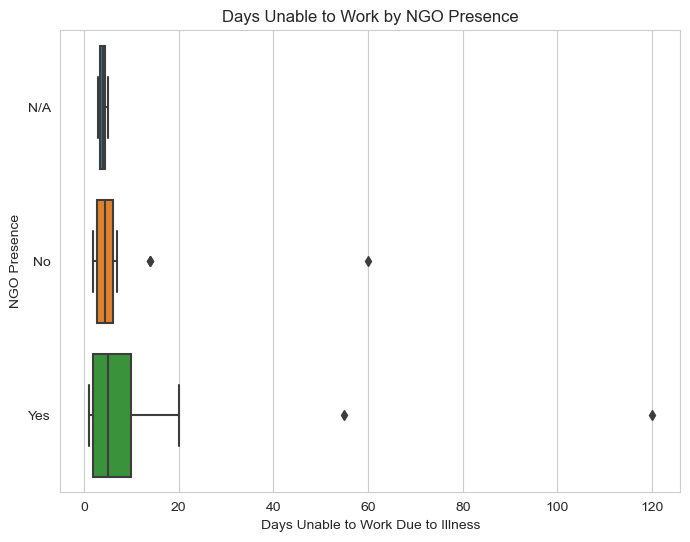

/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

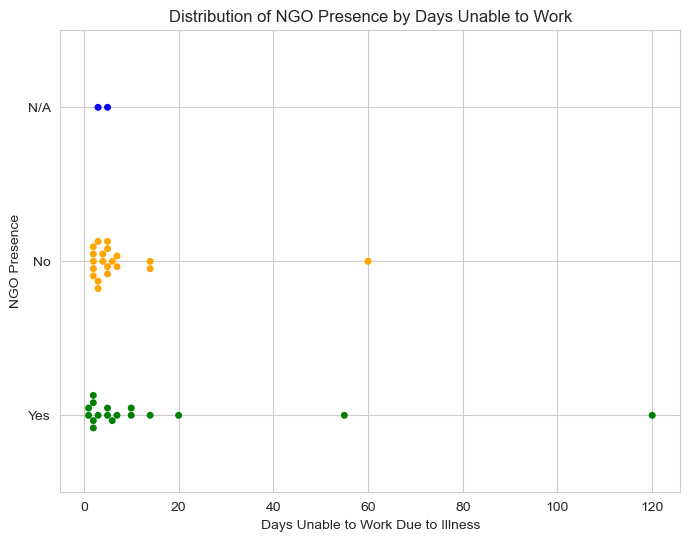

T-Statistic: 1.0670081832176477
P-Value: 0.2932731138444064
There is no significant difference in days unable to work between communities with and without NGOs.
Number of 'No': 20
Number of 'Yes': 17


In [23]:
# Relate morbidity and mortality differences against each community's level of NGO intervention. Positive perceived impact or not?
# Is there any non-governmental organization working in your community?

df_copy = df.copy()

# Remove missing data
df_copy.dropna(subset=['Days Unable to Work'], inplace=True)

# Preprocess the column 'Is there any non-governmental organization working in your community?'
df_copy['NGO Presence'] = df_copy['Is there any non-governmental organization working in your community?'].astype(str).apply(
    lambda x: 'Yes' if 'yes' in x.lower() else ('No' if 'no' in x.lower() else 'N/A'))

# Descriptive statistics
print(df_copy.describe())

# Set seaborn style with grid
sns.set_style("whitegrid")

# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Days Unable to Work', y='NGO Presence', data=df_copy)
plt.xlabel('Days Unable to Work Due to Illness')
plt.ylabel('NGO Presence')
plt.title('Days Unable to Work by NGO Presence')
plt.show()

# Define a color palette
palette_dict = {'N/A': 'blue', 'No': 'orange', 'Yes': 'green'}

# Swarm plot with custom colors
plt.figure(figsize=(8, 6))
sns.swarmplot(x='Days Unable to Work', y='NGO Presence', data=df_copy, palette=palette_dict)
plt.xlabel('Days Unable to Work Due to Illness')
plt.ylabel('NGO Presence')
plt.title('Distribution of NGO Presence by Days Unable to Work')
plt.grid(True) 
plt.show()

# Statistical analysis
# Separate data for communities with and without NGOs
with_ngos = df_copy[df_copy['NGO Presence'] == 'Yes']
without_ngos = df_copy[df_copy['NGO Presence'] == 'No']

# Perform t-test
t_stat, p_value = ttest_ind(with_ngos['Days Unable to Work'], without_ngos['Days Unable to Work'])
print('T-Statistic:', t_stat)
print('P-Value:', p_value)

# Interpretation
alpha = 0.05
if p_value < alpha:
    print('There is a significant difference in days unable to work between communities with and without NGOs.')
else:
    print('There is no significant difference in days unable to work between communities with and without NGOs.')
    
# Count the number of 'No's and 'Yes's in the 'NGO Presence' column
count_ngos = df_copy['NGO Presence'].value_counts()

print("Number of 'No':", count_ngos['No'])
print("Number of 'Yes':", count_ngos['Yes'])


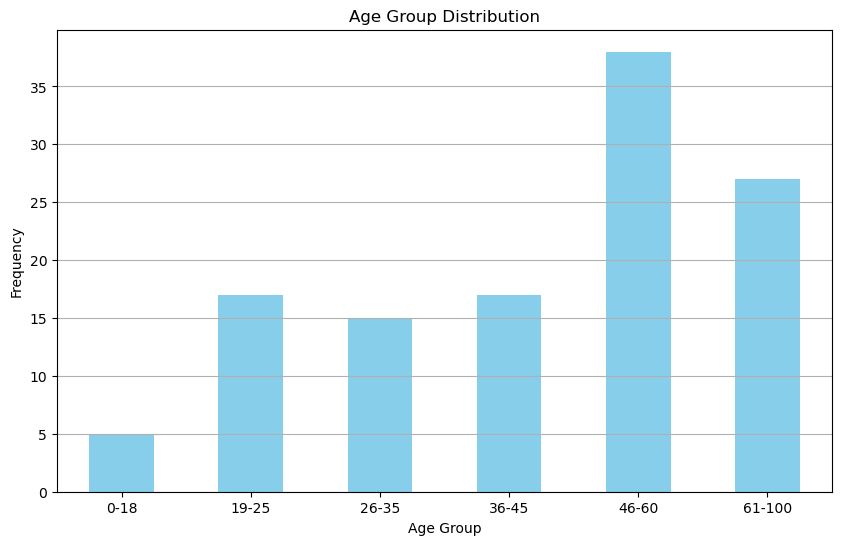

In [46]:
# Define age bins and labels
bins = [0, 18, 25, 35, 45, 60, 100]
labels = ['0-18', '19-25', '26-35', '36-45', '46-60', '61-100']

# Create age groups using pd.cut
df['Age Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Count the frequency of each age group
age_group_counts = df['Age Group'].value_counts().sort_index()

# Plotting the bar plot
plt.figure(figsize=(10, 6))
age_group_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.title('Age Group Distribution')
plt.xticks(rotation=0)
plt.grid(axis='y')

# Show the plot
plt.show()